# TACO Inspection Demo

This notebook contains several independent scripts that show how to load and visualize the dataset stats and annotated images:
- Section 1 shows the dataset stats
- Section 2 show the class hierarchical structure: super classes and classes
- Section 3 shows TACO images along with their segmentation masks

But first we need to load the annotations and some python libraries:

In [1]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

dataset_path = '/dtu/datasets1/02514/data_wastedetection'
anns_file_path = dataset_path + '/' + 'annotations.json'

# Read annotations
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())

categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']
nr_cats = len(categories)
nr_annotations = len(anns)
nr_images = len(imgs)

# Load categories and super categories
cat_names = []
super_cat_names = []
super_cat_ids = {}
super_cat_last_name = ''
nr_super_cats = 0
for cat_it in categories:
    cat_names.append(cat_it['name'])
    super_cat_name = cat_it['supercategory']
    # Adding new supercat
    if super_cat_name != super_cat_last_name:
        super_cat_names.append(super_cat_name)
        super_cat_ids[super_cat_name] = nr_super_cats
        super_cat_last_name = super_cat_name
        nr_super_cats += 1

print('Number of super categories:', nr_super_cats)
print('Number of categories:', nr_cats)
print('Number of annotations:', nr_annotations)
print('Number of images:', nr_images)

Number of super categories: 28
Number of categories: 60
Number of annotations: 4784
Number of images: 1500


In [2]:
id_im = 100

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!
batch_11/000028.jpg
[0.0, 1139.0, 2394.0, 1963.0]
[618.0, 1224.0, 249.0, 242.0]
[984.0, 901.0, 440.0, 633.0]
[1014.0, 805.0, 447.0, 362.0]
[1196.0, 549.0, 262.0, 276.0]
[1479.0, 772.0, 596.0, 328.0]
[335.0, 641.0, 620.0, 511.0]


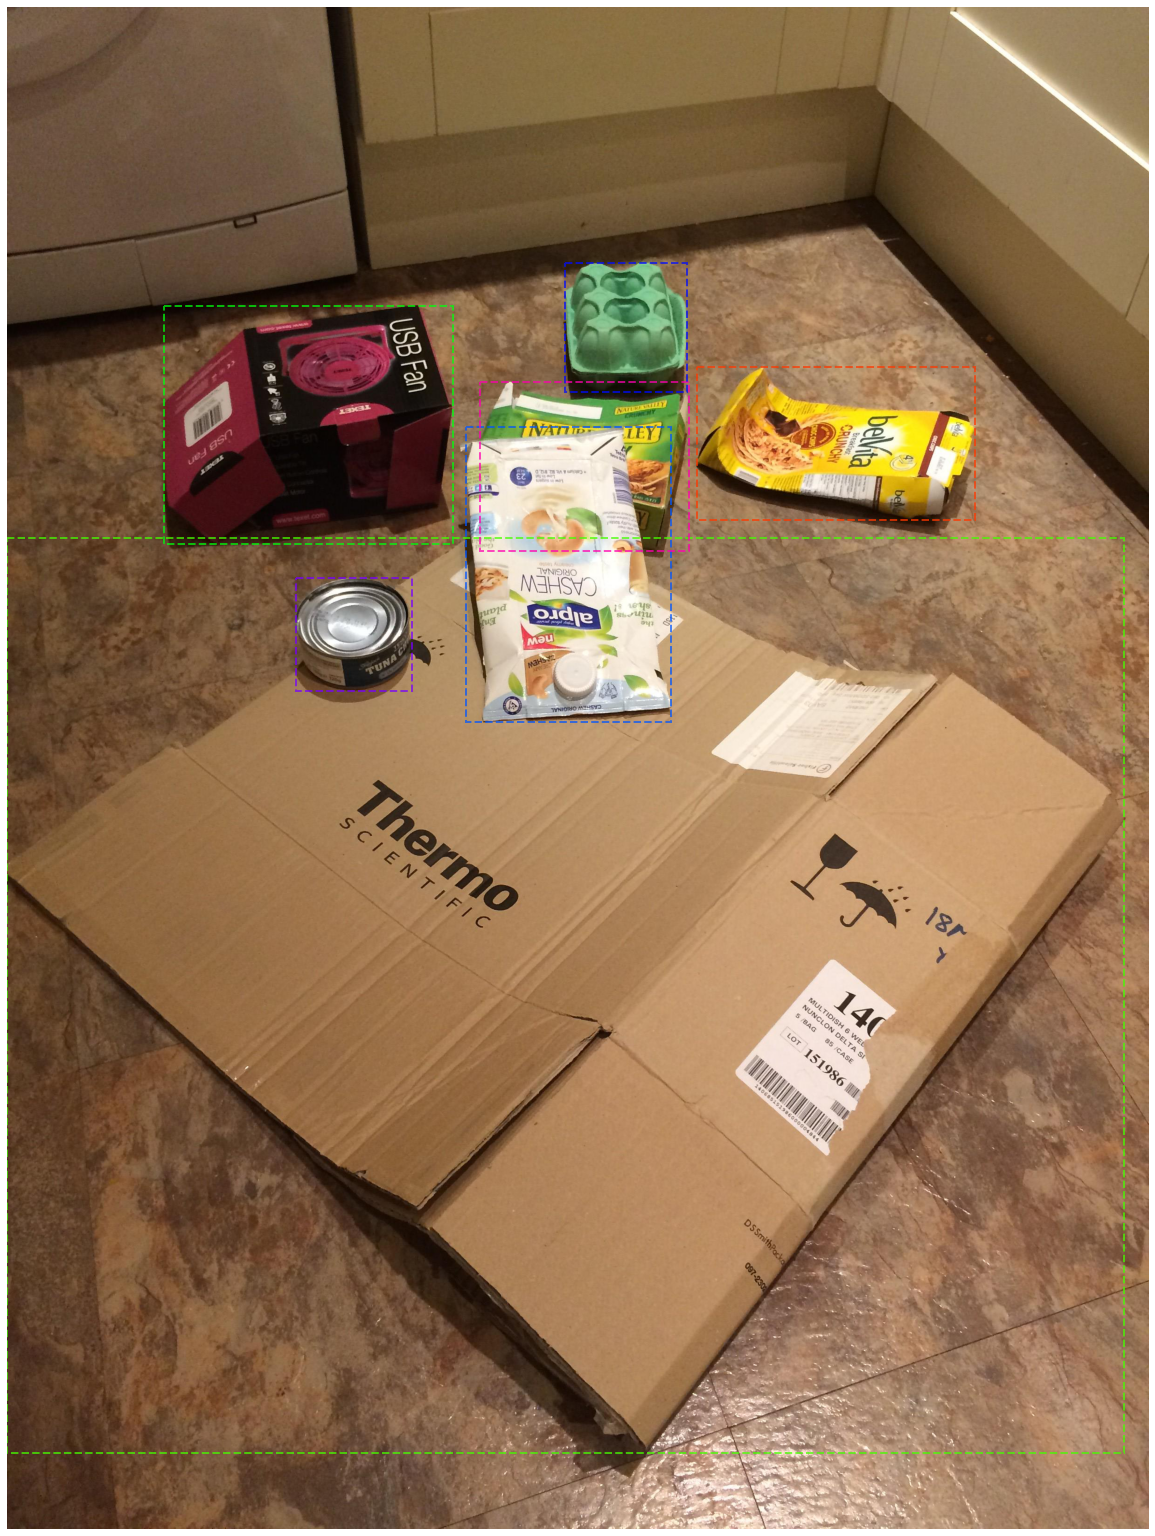

In [15]:
from PIL import Image, ExifTags
from pycocotools.coco import COCO
from matplotlib.patches import Polygon, Rectangle
from matplotlib.collections import PatchCollection
import colorsys
import random
import pylab

# User settings
image_filepath = 'batch_11/000028.jpg'
pylab.rcParams['figure.figsize'] = (28,28)
####################

# Obtain Exif orientation tag code
for orientation in ExifTags.TAGS.keys():
    if ExifTags.TAGS[orientation] == 'Orientation':
        break

# Loads dataset as a coco object
coco = COCO(anns_file_path)

# Find image id
img_id = -1
for img in imgs:
    if img['file_name'] == image_filepath:
        img_id = img['id']
        break

# Show image and corresponding annotations
if img_id == -1:
    print('Incorrect file name')
else:

    # Load image
    print(image_filepath)
    image_filepath = imgs[id_im]['file_name']
    I = Image.open(data_path + '/' + image_filepath)

    # Load and process image metadata
    if I._getexif():
        exif = dict(I._getexif().items())
        # Rotate portrait and upside down images if necessary
        if orientation in exif:
            if exif[orientation] == 3:
                I = I.rotate(180,expand=True)
            if exif[orientation] == 6:
                I = I.rotate(270,expand=True)
            if exif[orientation] == 8:
                I = I.rotate(90,expand=True)

    # Show image
    fig,ax = plt.subplots(1)
    plt.axis('off')
    plt.imshow(I)

    # Load mask ids
    annIds = coco.getAnnIds(imgIds=100, catIds=[], iscrowd=None)
    anns_sel = coco.loadAnns(annIds)

    # Show annotations
    for ann in anns_sel:
        color = colorsys.hsv_to_rgb(np.random.random(),1,1)
        [x, y, w, h] = ann['bbox']
        print(ann['bbox'])
        rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                         facecolor='none', alpha=0.7, linestyle = '--')
        ax.add_patch(rect)

    plt.show()

In [20]:
basewidth = 700
wpercent = (basewidth/float(I.size[0]))
hsize = int((float(I.size[1])*float(wpercent)))
I = I.resize((basewidth,hsize), Image.ANTIALIAS)

[  0 186 391 320]
[100 200  40  39]
[160 147  71 103]
[165 131  73  59]
[195  89  42  45]
[241 126  97  53]
[ 54 104 101  83]


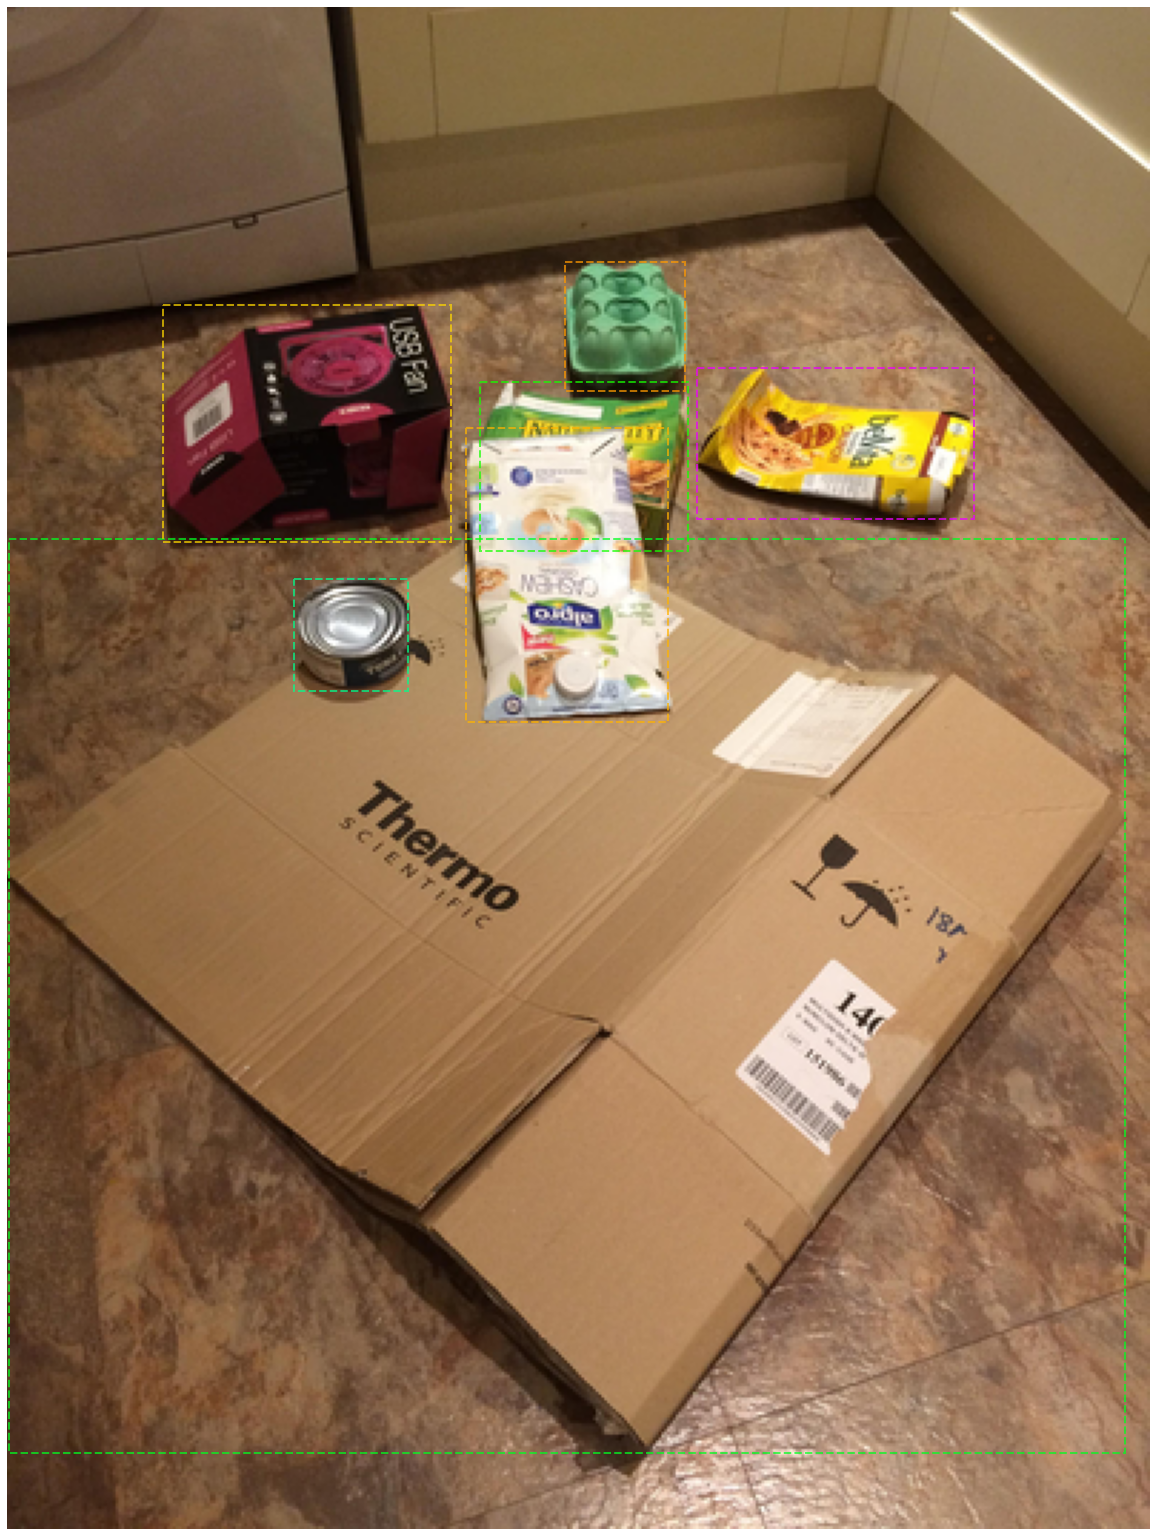

In [40]:
fig,ax = plt.subplots(1)
plt.axis('off')
plt.imshow(I)

# Load mask ids
annIds = coco.getAnnIds(imgIds=100, catIds=[], iscrowd=None)
anns_sel = coco.loadAnns(annIds)

# Show annotations
for bb in bbox_gt:
    color = colorsys.hsv_to_rgb(np.random.random(),1,1)
    [x, y, w, h] = bb
    print(bb)
    rect = Rectangle((x,y),w,h,linewidth=2,edgecolor=color,
                     facecolor='none', alpha=0.7, linestyle = '--')
    ax.add_patch(rect)

plt.show()

# START HERE

In [1]:
#matplotlib inline
import glob
from math import floor
import os

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import PIL.Image as Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from torch import utils

import random
from math import floor
import cv2
import pickle


In [2]:
def selective_search(image):
    # return region proposals of selective searh over an image
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    return ss.process()

In [3]:
def calculate_IoU(bb1, bb2):
  # calculate IoU(Intersection over Union) of 2 boxes 
  # **IoU = Area of Overlap / Area of Union
  # https://github.com/Hulkido/RCNN/blob/master/RCNN.ipynb

    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
    # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    # calculate Overlapping area
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
    union_area = bb1_area + bb2_area - intersection_area

    return intersection_area / union_area

In [4]:
def load_image_data(id_im, categories, anns, imgs, basewidth=600, data_path='/dtu/datasets1/02514/data_wastedetection'):
    cat_names = []
    super_cat_names = []
    super_cat_ids = {}
    super_cat_last_name = ''
    nr_super_cats = 0
    for cat_it in categories:
        cat_names.append(cat_it['name'])
        super_cat_name = cat_it['supercategory']
        # Adding new supercat
        if super_cat_name != super_cat_last_name:
            super_cat_names.append(super_cat_name)
            super_cat_ids[super_cat_name] = nr_super_cats
            super_cat_last_name = super_cat_name
            nr_super_cats += 1
    
    image_filepath = imgs[id_im]['file_name']
    image = Image.open(data_path + '/' + image_filepath)
    bbox = []
    labels = []
    for d in anns:
        if d['image_id'] == id_im:
            cat = [cat for cat in categories if cat['id'] == d['category_id']][0]
            label = super_cat_ids[cat['supercategory']]
            labels.append(label)
            bbox.append(d['bbox'])
    bbox = torch.as_tensor(bbox)
    wpercent = (basewidth/float(image.size[0]))
    hsize = int((float(image.size[1])*float(wpercent)))
    image = image.resize((basewidth,hsize), Image.ANTIALIAS)
    bbox_gt = (bbox*wpercent).numpy().astype(int)
    
    return np.array(image), bbox_gt, labels

In [5]:
def weirdbbox2bbox(x,y,w,h):
    x1, y1 = x, y
    x2, y2 = x+w, y+h
    return {'x1':x1, 'y1':y1, 'x2':x2, 'y2':y2}

In [6]:
def get_proposals(image, bbox_gt, labels, img_id, IoU_threshold=0.5, target_object_rate=0.3):
    obj_counter = 0
    bg_counter = 0
    train_images=[]
    train_labels=[]



    rects = selective_search(image)
    random.shuffle(rects)

    for (x, y, w, h) in rects:
        # apply padding
        best_iou = 0
        bbox_est = weirdbbox2bbox(x,y,w,h)
        for i, gt_bbox in enumerate(bbox_gt):
            [x,y,w,h]=gt_bbox
            gt_bbox = weirdbbox2bbox(x,y,w,h)
            iou = calculate_IoU(gt_bbox, bbox_est)

            if iou >= IoU_threshold: # if object(RoI > 0.5)
                if iou > best_iou:
                    best_iou = iou
                    best_i = i

        if best_iou > 0:
            obj_counter += 1
            cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :]
            train_images.append(cropped)
            train_labels.append([labels[best_i], bbox_gt[best_i], bbox_est, img_id])

        else:
            if (bg_counter+obj_counter) > 0:
                if obj_counter/(bg_counter+obj_counter) >= target_object_rate:
                    bg_counter+=1
                    cropped = image[bbox_est['y1']:bbox_est['y2'], bbox_est['x1']:bbox_est['x2'], :]
                    train_images.append(cropped)
                    train_labels.append([28, np.array([1,1,1,1]), bbox_est, img_id])

    return train_images, train_labels


In [33]:
class WasteInWild(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform):
        'Initialization'
        self.data_path = data_path
        self.transform = transform
        self.images = images
        self.labels = labels

    def __len__(self):
        'Returns the total number of samples'
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        X = self.transform(image)
        y = self.labels[idx][0]
        return  X, y  

def load_full_data(data_path = ''):
    print('[*] Loading dataset from', data_path)
    with open(data_path + 'train_images.pkl', 'rb') as f:
        train_images=pickle.load(f)
    with open(data_path + 'train_labels.pkl', 'rb') as f:
        train_labels=pickle.load(f)
    with open(data_path + 'val_images.pkl', 'rb') as f:
        val_images=pickle.load(f)
    with open(data_path + 'val_labels.pkl', 'rb') as f:
        val_labels=pickle.load(f)
        
    return train_images, train_labels, val_images, val_labels
    
def get_loaders(train_images, train_labels, val_images, val_labels, batch_size=16):
    size = 112 


    train_transform = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((size, size)), 
                                        transforms.ToTensor(), 
                                        ])
    val_transform = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((size, size)), 
                                        transforms.ToTensor(), 
                                        ])

    trainset = WasteInWild(train_images, train_labels, transform=train_transform)
    train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=3)
    
    valset = WasteInWild(val_images, val_labels, transform=val_transform)
    val_loader = DataLoader(valset, batch_size=batch_size, shuffle=False, num_workers=3)

    return train_loader, val_loader

In [53]:
def prepare_datasets(categories, anns, imgs, data_path = '', seed = 4):
    
    random.seed(seed)
    fullIdList = list(range(len(imgs)))
    random.shuffle(fullIdList)

    train_ids = fullIdList[0:floor(len(imgs)*0.6)]
    val_ids = fullIdList[floor(len(imgs)*0.6):(floor(len(imgs)*0.6)+floor(len(imgs)*0.2))]
    test_ids = fullIdList[floor(len(imgs)*0.8):(floor(len(imgs)*0.8)+floor(len(imgs)*0.2))]
    print(f'train: {len(train_ids)}, val: {len(val_ids)}, test: {len(test_ids)}')
    
    train_ims = []
    train_labs = []
    for id_im in train_ids:
        im, bbox_gt, labels = load_image_data(id_im=id_im, categories=categories, anns=anns, imgs=imgs)
        train_images, train_labels = get_proposals(im, bbox_gt, labels, id_im, IoU_threshold=0.5)
        train_ims += train_images
        train_labs += train_labels
    print(f'train len: {len(train_ims)}')
    
    val_ims = []
    val_labs = []
    for id_im in val_ids:
        im, bbox_gt, labels = load_image_data(id_im=id_im, categories=categories, anns=anns, imgs=imgs)
        val_images, val_labels = get_proposals(im, bbox_gt, labels, id_im, IoU_threshold=0.5)
        val_ims += val_images
        val_labs += val_labels
    print(f'val len: {len(val_ims)}')
    
    print('[*] Dataset generated! Saving labels to', data_path)
    with open(data_path + 'train_labels.pkl', 'wb') as f:
        pickle.dump(train_labs, f)
    with open(data_path + 'train_images.pkl', 'wb') as f:
        pickle.dump(train_ims, f)  
    with open(data_path + 'val_labels.pkl', 'wb') as f:
        pickle.dump(val_labs, f)
    with open(data_path + 'val_images.pkl', 'wb') as f:
        pickle.dump(val_ims, f)   
    

In [25]:
def get_device():
    if torch.cuda.is_available():
        print("The code will run on GPU.")
    else:
        print("The code will run on CPU")
    return torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [26]:
class FinetuneResnet50(nn.Module):
    def __init__(self, num_classes, pretrained = True):
        super(FinetuneResnet50, self).__init__()

        self.model = models.resnet50(pretrained=pretrained)
        self.fc1 = nn.Linear(2048, 2048)
        self.fc2 = nn.Linear(2048, num_classes)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)

        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

In [34]:
def train(model, optimizer, train_loader, val_loader, device, num_epochs=50, patience = 10):
   
        
    def loss_fun(output, target):
        return F.cross_entropy(output, target)
    out_dict = {'train_acc': [],
              'test_acc': [],
              'train_loss': [],
              'test_loss': []}
    for epoch in range(num_epochs):
        print(epoch)
        
        model.train()
        #For each epoch
        train_correct = 0
        train_loss = []
        for minibatch_no, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            #Zero the gradients computed for each weight
            optimizer.zero_grad()
            #Forward pass your image through the network
            output = model(data)
            #Compute the loss
            loss = loss_fun(output, target)
            #Backward pass through the network
            loss.backward()
            #Update the weights
            optimizer.step()

            train_loss.append(loss.item())
            #Compute how many were correctly classified
            predicted = F.softmax(output, dim=1).argmax(1)
            train_correct += (target==predicted).sum().cpu().item()
#         #Comput the test accuracy
#         test_loss = []
#         test_correct = 0
#         model.eval()
#         for data, target in test_loader:
#             data, target = data.to(device), target.to(device)
#             with torch.no_grad():
#                 output = model(data)
#             test_loss.append(loss_fun(output, target).cpu().item())
#             predicted =  F.softmax(output, dim=1).argmax(1)
#             test_correct += (target==predicted).sum().cpu().item()
        out_dict['train_acc'].append(train_correct/len(train_loader.dataset))
#         out_dict['test_acc'].append(test_correct/len(test_loader.dataset))
        out_dict['train_loss'].append(np.mean(train_loss))
#         out_dict['test_loss'].append(np.mean(test_loss))
#         print(f"Loss train: {np.mean(train_loss):.3f}\t test: {np.mean(test_loss):.3f}\t",
#               f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%\t test: {out_dict['test_acc'][-1]*100:.1f}%\t",
#               f"Memory allocated: {torch.cuda.memory_allocated(device=device)/1e9:.1f} GB")
        print(f"Loss train: {np.mean(train_loss):.3f}\t",f"Accuracy train: {out_dict['train_acc'][-1]*100:.1f}%")
    # Early stopping 
#         if epoch > 10 and out_dict['test_acc'][-1] < out_dict['test_acc'][-2]:
#             patience -= 1
#             if patience == 0:
#                 print("Early stopping")
#                 break

    return out_dict

In [51]:
data_path='/dtu/datasets1/02514/data_wastedetection'
anns_file_path = data_path + '/' + 'annotations.json'
with open(anns_file_path, 'r') as f:
    dataset = json.loads(f.read())
    
categories = dataset['categories']
anns = dataset['annotations']
imgs = dataset['images']    

In [52]:
id_im = 100
IoU_threshold=0.5
target_object_rate=0.3

In [ ]:
prepare_datasets(categories=categories, anns=anns, imgs=imgs)

train: 900, val: 300, test: 300


In [47]:
device = get_device()

train_images, train_labels, val_images, val_labels = load_full_data()
train_loader, val_loader = get_loaders(train_images, train_labels, val_images, val_labels, batch_size=16)


model = FinetuneResnet50(29)
# model = ResNet(3,16, num_res_blocks=8)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


training_stats = train(model, optimizer, train_loader, val_loader,  device, 10)

torch.save(model.state_dict(), 'model.pkl')

The code will run on GPU.
[*] Loading dataset from 
0
Loss train: 1.177	 Accuracy train: 72.6%
1
Loss train: 0.701	 Accuracy train: 78.5%
2
Loss train: 0.477	 Accuracy train: 83.8%
3
Loss train: 0.465	 Accuracy train: 86.5%
4
Loss train: 0.363	 Accuracy train: 89.0%
5
Loss train: 0.255	 Accuracy train: 92.6%
6
Loss train: 0.576	 Accuracy train: 84.6%
7
Loss train: 0.392	 Accuracy train: 89.5%
8
Loss train: 0.255	 Accuracy train: 91.6%
9
Loss train: 0.323	 Accuracy train: 90.1%
